# Decision Trees to Predict Player Positions

In this notebook we'll be diving into an algorithm called *decision trees*. A decision tree is a decision support tool that uses a tree-like graph or model of decisions and their possible consequences. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
For example, if you wanted to make use of a decision tree to classify all the instruments that can be found in a music shop, you might construct the one shown here:


![Decision_tree]( https://github.com/jdwlinde/Explore-Learning/blob/master/decision_tree_instruments.png?raw=TRUE )

Binary trees can be very efficient. By designing your tree carefully, the binary splitting can cut the number of options approximately in half with each question. This will very quickly narrow the options even among a large number of classes.

Clearly a lot of thought needs to go into what questions are asked at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.

Let's look at some practical examples to see decision trees in action.

### Importing Data

We will look at the Fifa 2018 players dataset and try to predict the position of the player based on his attacking and defending abilities. Let's start by importing the data and looking at the first few entries.

In [1]:
!pip install sqlalchemy
!pip install psycopg2

distributed 1.21.8 requires msgpack, which is not installed.


distributed 1.21.8 requires msgpack, which is not installed.


In [2]:
from sqlalchemy import create_engine
import psycopg2

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [3]:
#connect to the sql dataset on AWS 
db_settings = {'host' : 'edsasoccerinstance.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com', 'dbname' : 'edsaLeagueSoccerDatabase', 'user' : 'edsaSoccer', 'password' : 'edsaSoccer'} 
conn_string = ' '.join(["{}='{}'".format(k, v) for k, v in db_settings.items()]) 
print (conn_string)
conn_rds = psycopg2.connect(conn_string) 
print('Created connection')

players = pd.read_sql_query("select * from players", con=conn_rds) 
players.head()

host='edsasoccerinstance.cnzbp4ndrpos.eu-west-1.rds.amazonaws.com' dbname='edsaLeagueSoccerDatabase' user='edsaSoccer' password='edsaSoccer'
Created connection


Name  Age                                            Photo  \
0  Cristiano Ronaldo   32   https://cdn.sofifa.org/48/18/players/20801.png   
1           L. Messi   30  https://cdn.sofifa.org/48/18/players/158023.png   
2             Neymar   25  https://cdn.sofifa.org/48/18/players/190871.png   
3          L. Suárez   30  https://cdn.sofifa.org/48/18/players/176580.png   
4           M. Neuer   31  https://cdn.sofifa.org/48/18/players/167495.png   

  Nationality                                 Flag  Overall  Potential  \
0    Portugal  https://cdn.sofifa.org/flags/38.png       94         94   
1   Argentina  https://cdn.sofifa.org/flags/52.png       93         93   
2      Brazil  https://cdn.sofifa.org/flags/54.png       92         94   
3     Uruguay  https://cdn.sofifa.org/flags/60.png       92         92   
4     Germany  https://cdn.sofifa.org/flags/21.png       92         92   

                  Club                                   Club Logo   Value  \
0       Real Madrid CF  https://cdn.sofifa.org/24/18/teams/243.png  €95.5M   
1         FC Barcelona  https://cdn.sofifa.org/24/18/teams/241.png   €105M   
2  Paris Saint-Germain   https://cdn.sofifa.org/24/18/teams/73.png   €123M   
3         FC Barcelona  https://cdn.sofifa.org/24/18/teams/241.png    €97M   
4     FC Bayern Munich   https://cdn.sofifa.org/24/18/teams/21.png    €61M   

   ...     RB   RCB   RCM   RDM    RF    RM    RS    RW   RWB    ST  
0  ...   61.0  53.0  82.0  62.0  91.0  89.0  92.0  91.0  66.0  92.0  
1  ...   57.0  45.0  84.0  59.0  92.0  90.0  88.0  91.0  62.0  88.0  
2  ...   59.0  46.0  79.0  59.0  88.0  87.0  84.0  89.0  64.0  84.0  
3  ...   64.0  58.0  80.0  65.0  88.0  85.0  88.0  87.0  68.0  88.0  
4  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 74 columns]

We want to have a label showing the position type of the player, e.g. forward or back. We will write a function to do this.

In [4]:
def position_type(s):    
    """"This function converts the individual positions (abbreviations) and classfies it
    as either a forward, midfielder, back or goal keeper"""
    
    if (s[-2] == 'T') | (s[-2] == 'W'):
        return 'Forward'
    elif s[-2] == 'M':
        return 'Midfielder'
    elif s[-2] == 'B':
        return 'Back'
    else:
        return 'GoalKeeper'

# Calculate columns of attacking ability, defending ability and position
players['Finishing'] = players['Finishing'].apply(lambda x: float(x[0:2]))
players['Standing tackle'] = players['Standing tackle'].apply(lambda x: float(x[0:2]))
players['Preferred Positions Type'] = players['Preferred Positions'].apply(lambda x: position_type(x))

In [5]:
# Data we will use
data = players[['Finishing', 'Standing tackle','Preferred Positions Type']]
data.head()

Finishing  Standing tackle Preferred Positions Type
0       94.0             31.0                  Forward
1       95.0             28.0                  Forward
2       89.0             24.0                  Forward
3       94.0             45.0                  Forward
4       13.0             10.0               GoalKeeper

Let's plot the attacking vs defending ability of the players as a scatterplot and colour the points based on position.

Text(0.5,1,'Attacking vs Defending Ability')

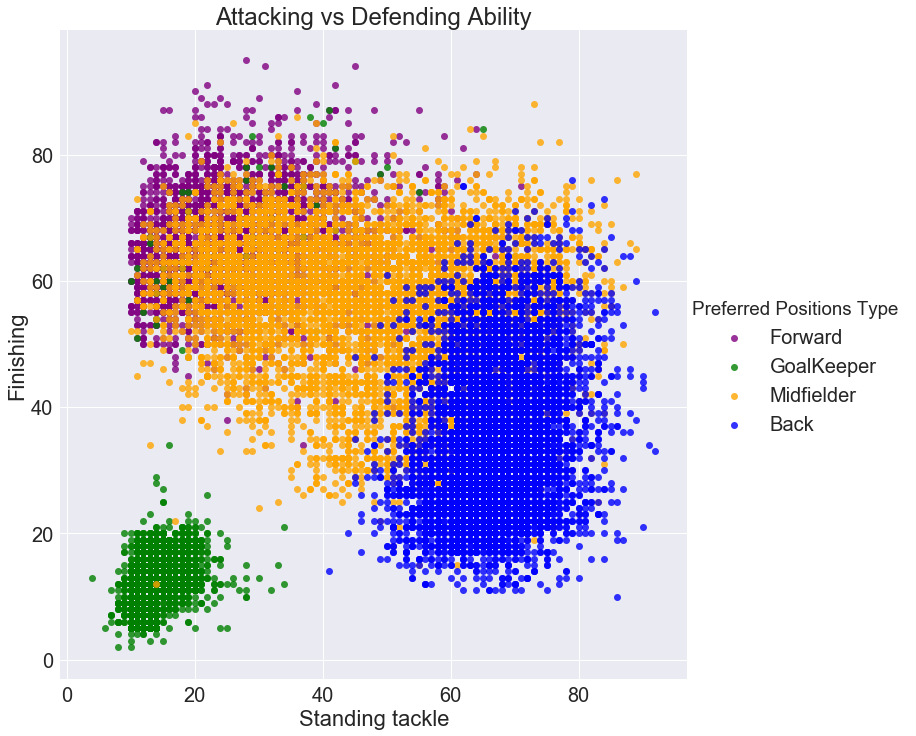

In [6]:
sns.lmplot(x='Standing tackle',
          y='Finishing',
          data=data,
          hue='Preferred Positions Type',
          size=10,
          aspect=1,
          fit_reg=False,
          palette=dict(Forward="purple", GoalKeeper="green", Midfielder="orange", Back="blue"))
plt.title('Attacking vs Defending Ability')

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.

### Creating a decision tree

Scikit-Learn has a estimater called ``DecisionTreeClassifier``. We will be using this to fit a decision tree to our data.

In [7]:
from sklearn.tree import DecisionTreeClassifier

The labels are currently a word in the format of a string. We need to encode the labels in order for the machine to interpret it. For this we use the ``LabelEncoder`` object.

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

Create features and labels and split it into a training and testing set.

In [9]:
from sklearn.model_selection import train_test_split

X = data[['Finishing','Standing tackle']]
y = encoder.fit_transform(data['Preferred Positions Type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

We will be making use of the following visualization tool by Jake VanderPlas available on GitHub.

In [10]:
def visualize_classifier(model, data, X, y, y_word, ax=None):

    # Plot the training points
    sns.lmplot(x='Standing tackle',
          y='Finishing',
          data=data,
          hue='Preferred Positions Type',
          size=10,
          aspect=1,
          fit_reg=False,
          palette=dict(Forward="purple", GoalKeeper="green", Midfielder="orange", Back="blue"))
    plt.title('Attacking vs Defending Ability')
    xlim = plt.xlim()
    ylim = plt.ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow',
                           clim=(y.min(), y.max()),
                           zorder=1)


Let us now see how our players get classified.

C:\Users\myles\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\myles\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


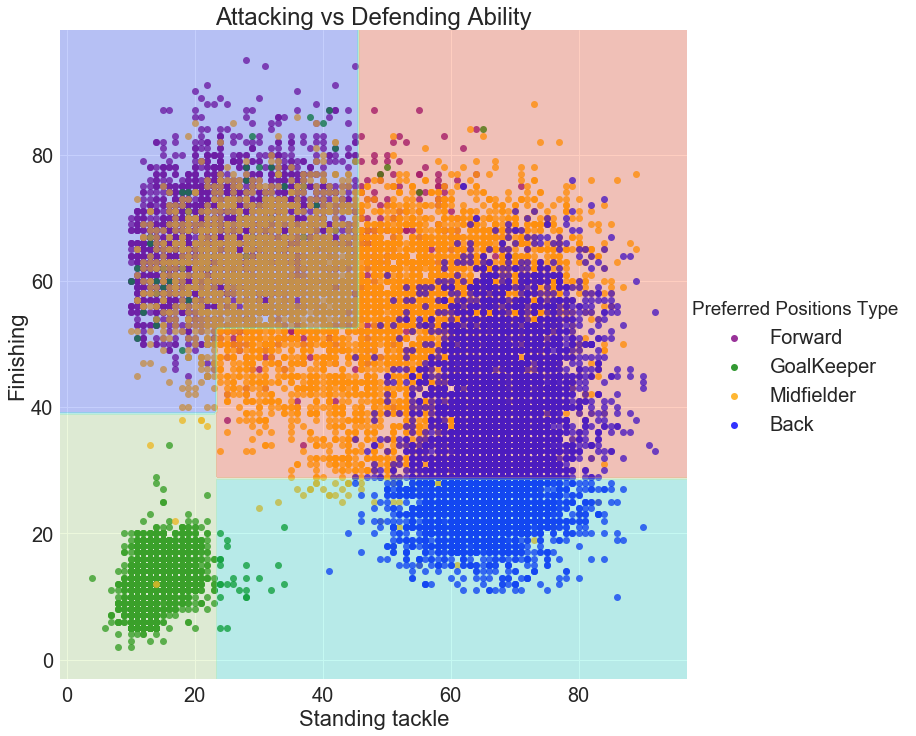

In [11]:
visualize_classifier(DecisionTreeClassifier(max_depth=3), 
                     data, 
                     X_train, 
                     y_train, 
                     pd.DataFrame(encoder.inverse_transform(y_train)))

The boundaries are shown by the colours, e.g. if a new data point falls within the light blue are, the prediction will be that the player is a Back.

Another way to view the model is to construct a tree-like structure. We will do this using **Graphviz**. 

In order to view the decision tree graph you will need to download the msi installer from https://graphviz.gitlab.io/_pages/Download/Download_windows.html.
It is important that the Graphviz executables are on your PATH. To edit the PATH variable, see https://www.java.com/en/download/help/path.xml and ensure that C:\Program Files (x86)\Graphviz2.38\bin is on your PATH.


In [12]:
from sklearn.tree import export_graphviz
import graphviz 

In [13]:
tree_position = DecisionTreeClassifier()
tree_position.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [14]:
dot_data = export_graphviz(tree_position, out_file=None, 
                         feature_names=['Finishing','Standing tackle'],  
                         class_names=['Forward','GoalKeeper','Midfielder', 'Back'],  
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = graphviz.Source(dot_data)  
graph 

There are various parameters we can tune to change the model, one of which is the **max depth** of the tree. Let's increase the **max depth** and see what happens.

C:\Users\myles\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\myles\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


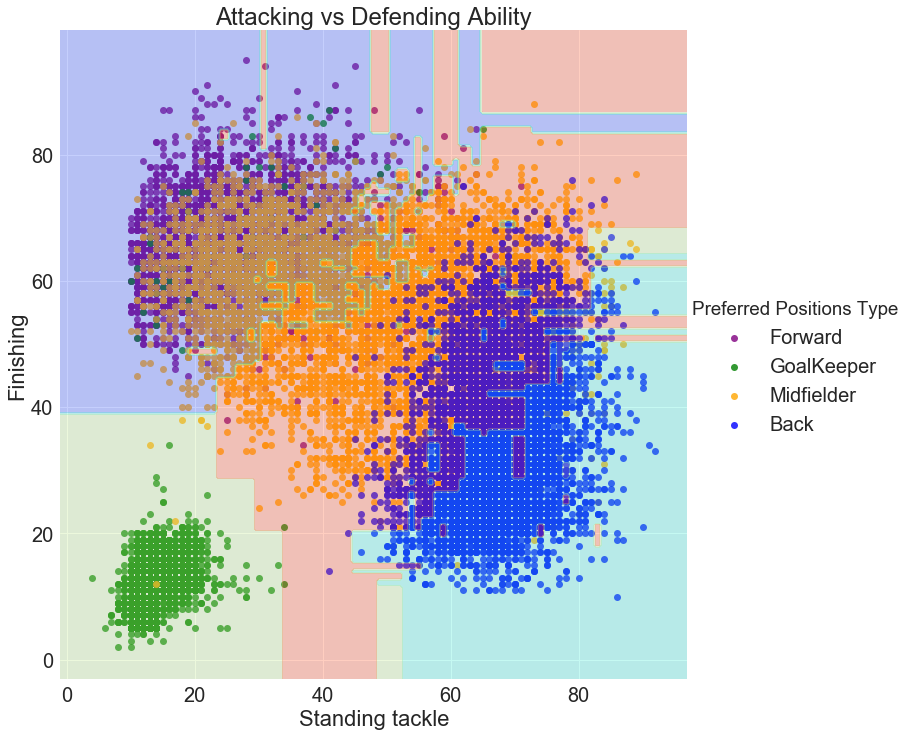

In [15]:
visualize_classifier(DecisionTreeClassifier(max_depth=10), 
                     data, 
                     X_train, 
                     y_train, 
                     pd.DataFrame(encoder.inverse_transform(y_train)))

As the depth increases, we start to see very strangely shaped classification regions.
It's clear that this is not the result of the true underlying data distribution, but more a result of the particular sampling or noise properties of the data.
So from this we can see that this decision tree, even at only five levels deep, is clearly over-fitting our data.

### Decision trees and over-fitting

A common problem with Decison trees is over-fitting. When using decision trees, one should be careful to not go too deep. This will lead to a model that fits your training data very well in stead of the actual underlying distributions.
To illustrate this over-fitting, we look at models trained on different subsets of the data. Below we train two different trees, each on half of the original data:

C:\Users\myles\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\myles\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)
C:\Users\myles\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\myles\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


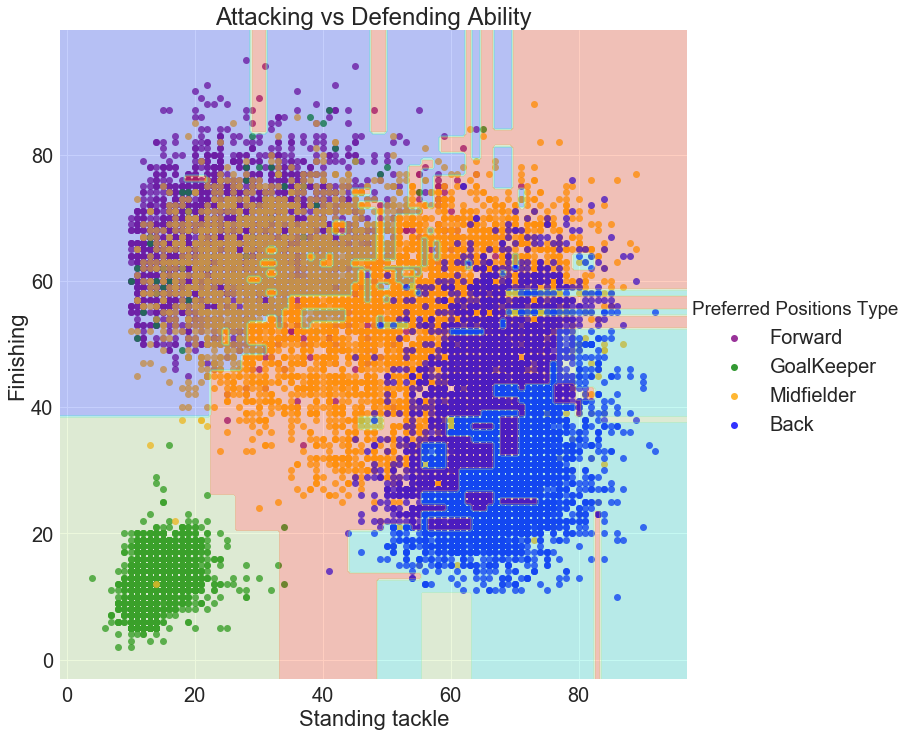

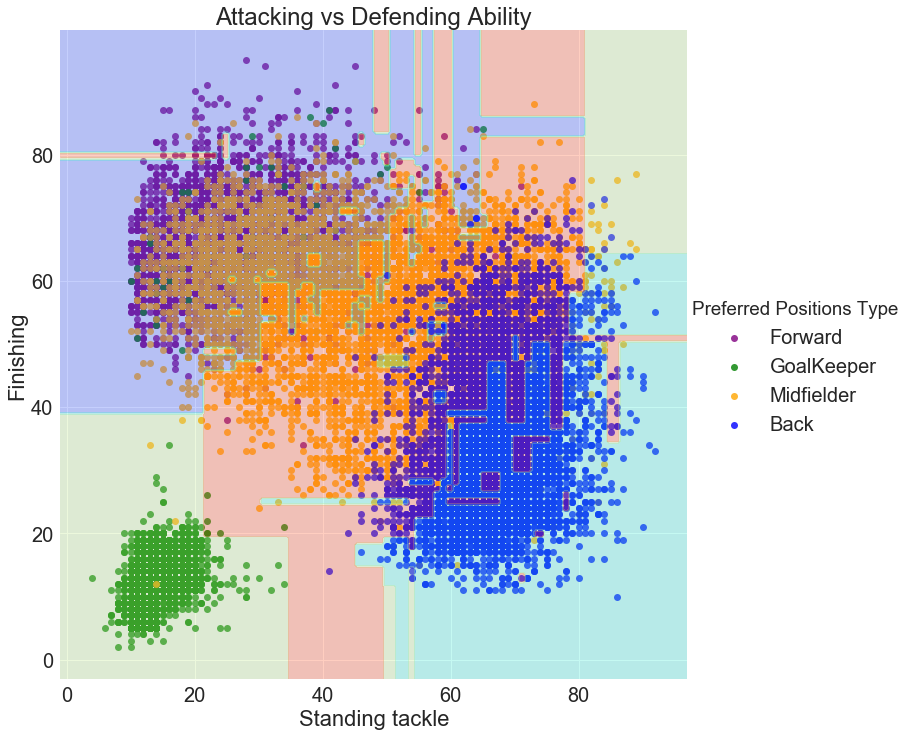

In [16]:
visualize_classifier(DecisionTreeClassifier(max_depth=10), 
                     data, 
                     X_train[0:6000], 
                     y_train[0:6000], 
                     pd.DataFrame(encoder.inverse_transform(y_train[0:6000])))

visualize_classifier(DecisionTreeClassifier(max_depth=10), 
                     data, 
                     X_train[6000:12000], 
                     y_train[6000:12000], 
                     pd.DataFrame(encoder.inverse_transform(y_train[6000:12000])))

As expected the trees will produce consistent results in some sections, but in others the two trees give very different classifications.

The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees in this case, we might come up with a better result.

If we were to continue with that thought, we can argue that just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

Algorithms such as this are an aggregation of simpler estimators, and are called *Ensemble methods*.

## Ensembles of Estimators: Random Forests
The notion that multiple overfitting estimators can be combined to reduce the effects of overfitting is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which over-fits the data, and aggregates the results to find a better classification. The nice thing about ensemble methods is that usually the sum is greater than any of the individual parts. 

An ensemble of randomized decision trees is known as a *random forest*. The results of the Random Forest is thus usually better than that of the individual Decision Trees that it is composed of. For example when doing classification the output of the Random Forest could be the mode of the multiple underlying decision trees and when doing regression the output could be the mean. 

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

C:\Users\myles\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\myles\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


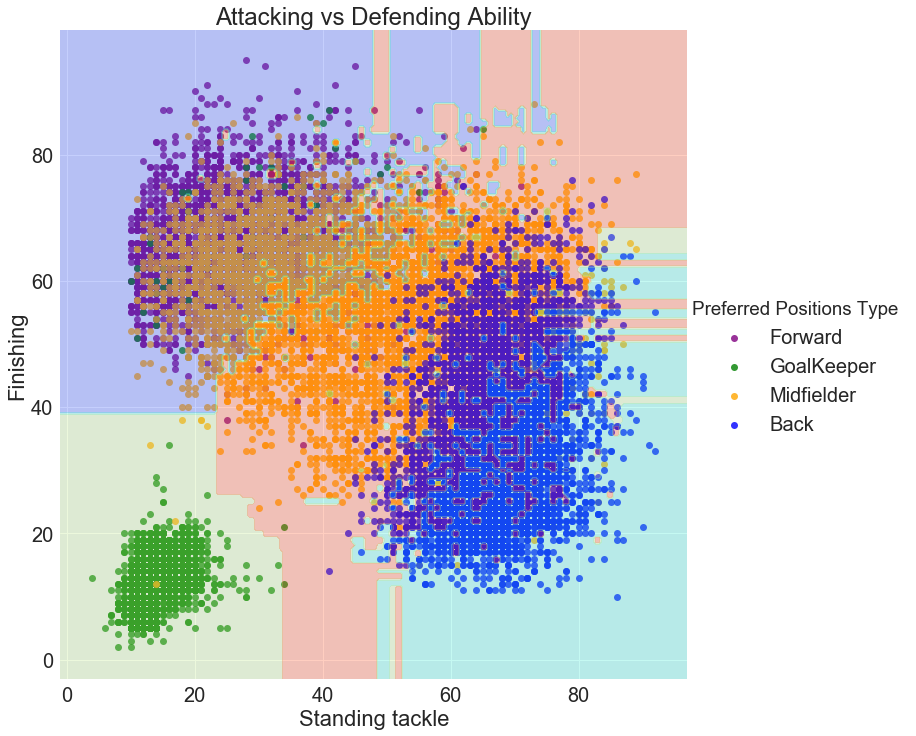

In [17]:
from sklearn.ensemble import BaggingClassifier

visualize_classifier(BaggingClassifier(n_estimators=100, random_state=1, max_samples=0.8), 
                     data, 
                     X_train, 
                     y_train, 
                     pd.DataFrame(encoder.inverse_transform(y_train)))

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the ``RandomForestClassifier`` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

C:\Users\myles\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\myles\Anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


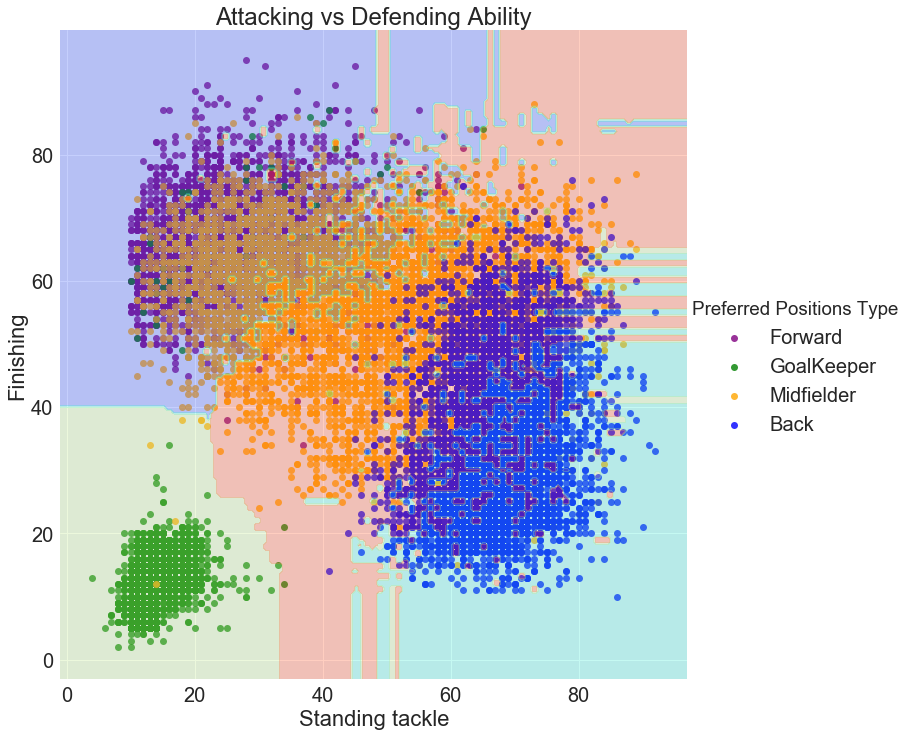

In [18]:
from sklearn.ensemble import RandomForestClassifier

visualize_classifier(RandomForestClassifier(n_estimators=100, random_state=1),
                     data, 
                     X_train, 
                     y_train, 
                     pd.DataFrame(encoder.inverse_transform(y_train)))

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is closer to our intuition about how the parameter space should be split.

## Testing the different models

In this section we will compare the prediction power of decision trees to ensemble methods (bagging & random forest). 

In [19]:
# Define our models
tree = DecisionTreeClassifier()
bagging = BaggingClassifier(n_estimators=100, random_state=1, max_samples=0.8)
forest = RandomForestClassifier(n_estimators=100, random_state=1)

In [20]:
# Fit our models
tree.fit(X_train, y_train)
bagging.fit(X_train, y_train)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [21]:
# Get predictions
pred_tree = tree.predict(X_test)
pred_bagging = bagging.predict(X_test)
pred_forest = forest.predict(X_test)

In order to assess results we will look at classification reports and confusion matrices.

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
print('Decision Tree:')
print(classification_report(y_test, pred_tree))

print('Bagging:')
print(classification_report(y_test, pred_bagging))

print('Random Forest:')
print(classification_report(y_test, pred_forest))

Decision Tree:
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      1912
          1       0.65      0.74      0.69      1054
          2       0.99      0.96      0.97       724
          3       0.70      0.59      0.64      2244

avg / total       0.74      0.75      0.74      5934

Bagging:
             precision    recall  f1-score   support

          0       0.78      0.82      0.80      1912
          1       0.68      0.70      0.69      1054
          2       0.99      0.96      0.98       724
          3       0.69      0.66      0.67      2244

avg / total       0.75      0.75      0.75      5934

Random Forest:
             precision    recall  f1-score   support

          0       0.78      0.82      0.80      1912
          1       0.67      0.70      0.69      1054
          2       0.99      0.96      0.98       724
          3       0.69      0.65      0.67      2244

avg / total       0.75      0.75      0.75      5934

In [24]:
labels = ['Forward','GoalKeeper','Midfielder','Back']

print('Decision Tree:')
print(pd.DataFrame(data=confusion_matrix(y_test, pred_tree), index=labels, columns=labels))

print('\n')

print('Bagging:')
print(pd.DataFrame(data=confusion_matrix(y_test, pred_bagging), index=labels, columns=labels))

print('\n')

print('Random Forest:')
print(pd.DataFrame(confusion_matrix(y_test, pred_forest), index=labels, columns=labels))

Decision Tree:
            Forward  GoalKeeper  Midfielder  Back
Forward        1628           0           0   284
GoalKeeper        2         775           5   272
Midfielder        0          18         697     9
Back            514         405           4  1321


Bagging:
            Forward  GoalKeeper  Midfielder  Back
Forward        1569           0           0   343
GoalKeeper        2         738           4   310
Midfielder        0          17         697    10
Back            440         333           1  1470


Random Forest:
            Forward  GoalKeeper  Midfielder  Back
Forward        1572           0           0   340
GoalKeeper        1         738           4   311
Midfielder        0          18         697     9
Back            438         339           2  1465


It looks like all 3 models performed similarly, with the ensemble method only just outperforming the decision tree. Can you tune the parameters to improve the results?

## Summary of Random Forests

This section contained a brief introduction to the concept of *ensemble estimators*, and in particular the random forest – an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability.
- The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.
- Random Forests are more robust than Decision Trees (as they are not prone to overfitting) and almost always result in a better accuracy. 

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.

In the next notebook we will look at how random forests can be used for feature selection!